# Parameter Efficient Fine Tuning: LoRA (Low Rank Adaptation)

In [ ]:
# Installing the keras_nlp libraries
!pip install keras_nlp
!pip install tensorflow==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: te

### Importing the Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
tf.__version__

'2.14.0'

### Setting from Mixed-Precision Training

In [ ]:
# mixed_precision = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy("mixed_float16")

### Defining Hyperparameters

In [ ]:
# General hyperparameters
BATCH_SIZE = 32
NUM_BATCHES = 500
EPOCHS = 1  # Can be set to a higher value for better results
MAX_SEQUENCE_LENGTH = 128
MAX_GENERATION_LENGTH = 200

GPT2_PRESET = "gpt2_base_en"

# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

### Loading the Dataset

In [ ]:
import tensorflow_datasets as tfds

dataset = tfds.load("reddit_tifu", split="train", as_supervised=True)
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/79740 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/reddit_tifu/short/1.1.2.incompleteIRWLYB/reddit_tifu-train.tfrecord*...:  …

Dataset reddit_tifu downloaded and prepared to /root/tensorflow_datasets/reddit_tifu/short/1.1.2. Subsequent calls will reuse this data.


<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
# Visualizing the dataset
n = 0

for document, title in dataset:
  if n < 3:
    print(document.numpy())
    print(title.numpy())
    print()
    n += 1
  else:
    break


b"me and a friend decided to go to the beach last sunday. we loaded up and headed out. we were about half way there when i decided that i was not leaving till i had seafood. \n\nnow i'm not talking about red lobster. no friends i'm talking about a low country boil. i found the restaurant and got directions. i don't know if any of you have heard about the crab shack on tybee island but let me tell you it's worth it. \n\nwe arrived and was seated quickly. we decided to get a seafood sampler for two and split it. the waitress bought it out on separate platters for us. the amount of food was staggering. two types of crab, shrimp, mussels, crawfish, andouille sausage, red potatoes, and corn on the cob. i managed to finish it and some of my friends crawfish and mussels. it was a day to be a fat ass. we finished paid for our food and headed to the beach. \n\nfunny thing about seafood. it runs through me faster than a kenyan \n\nwe arrived and walked around a bit. it was about 45min since we a

### Batching and Prefetching

We'll now batch the dataset and retain only the `document` field because we are fine-tuning the model on the next word prediction task. Take a subset of the dataset for the purpose of this example.

In [ ]:
train_dataset = dataset.map(lambda document, title: document).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.take(NUM_BATCHES)
train_dataset

<_TakeDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

## LoRA GPT-2

In this section, we discuss the technical details of LoRA, build a LoRA GPT-2
model, fine-tune it and generate text.

### What exactly is LoRA?

LoRA is a parameter-efficient fine-tuning technique for LLMs. It freezes the
weights of the LLM, and injects trainable rank-decomposition matrices. Let's
understand this more clearly.

Assume we have an `n x n` pre-trained dense layer (or weight matrix), `W0`. We
initialize two dense layers, `A` and `B`, of shapes `n x rank`, and `rank x n`,
respectively. `rank` is much smaller than `n`. In the paper, values between 1
and 4 are shown to work well.


#### LoRA equation

The original equation is `output = W0x + b0`, where `x` is the input, `W0` and
`b0` are the weight matrix and bias terms of the original dense layer (frozen).
The LoRA equation is: `output = W0x + b0 + BAx`, where `A` and `B` are the
rank-decomposition matrices.

LoRA is based on the idea that updates to the weights of the pre-trained
language model have a low "intrinsic rank" since pre-trained language models are
over-parametrized. Predictive performance of full fine-tuning can be replicated
even by constraining `W0`'s updates to low-rank decomposition matrices.

<p align="center">
  <img src="https://i.imgur.com/f4TFqMi.png" alt="lora_diagram" height="250"/>
</p>
<br>

#### Number of trainable parameters

Let's do some quick math. Suppose `n` is 768, and `rank` is 4. `W0` has
`768 x 768 = 589,824` parameters, whereas the LoRA layers, `A` and `B` together
have `768 x 4 + 4 x 768 = 6,144` parameters. So, for the dense layer, we go from
`589,824` trainable parameters to `6,144` trainable parameters!

#### Why does LoRA reduce memory footprint?

Even though the total number of parameters increase (since we are adding LoRA
layers), the memory footprint reduces, because the number of trainable
parameters reduces. Let's dive deeper into this.

The memory usage of a model can be split into four parts:

- Model memory: This is the memory required to store the model weights. This
will be slightly higher for LoRA than GPT-2.
- Forward pass memory: This mostly depends on batch size, sequence length, etc.
We keep this constant for both models for a fair comparison.
- Backward pass memory: This is the memory required to store the gradients.
Note that the gradients are computed only for the trainable parameters.
- Optimizer memory: This is the memory required to store the optimizer state.
For example, the Adam optimizer stores the "1st moment vectors" and
"2nd moment vectors" for the trainable parameters.

Since, with LoRA, there is a huge reduction in the number of trainable
parameters, the optimizer memory and the memory required to store the gradients
for LoRA is much less than GPT-2. This is where most of the memory savings
happen.

#### Why is LoRA so popular?

- Reduces GPU memory usage;
- Faster training; and
- No additional inference latency.

### Create LoRA layer

According to the technical description above, let's create a LoRA layer. In
a transformer model, the LoRA layer is created and injected for the query and
value projection matrices. In `tf.keras.layers.MultiHeadAttention`, the query/value
projection layers are `tf.keras.layers.EinsumDense` layers.

In [ ]:
import math

class LoraLayer(tf.keras.layers.Layer):
  """Layer to define the LoRA method from fine tuning a Large Language Model"""

  def __init__(self, original_layer, rank=4, alpha=32, trainable=False, **kwargs):
    # We want to keep the name of this layer the same as the original dense layer.
    original_layer_config = original_layer.get_config()
    name = original_layer_config["name"]  # Extracting the name of the original layer

    # Remoing the name value from the kwargs dictionary
    kwargs.pop("name", None)

    # Passing the required argument to the constructor of the parent class
    super().__init__(name=name, trainable=trainable, **kwargs)

    self.rank = rank
    self.alpha = alpha

    self._scale = alpha / rank
    self._num_heads = original_layer_config["output_shape"][-2]
    self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

    # Original Dense layer
    self.original_layer = original_layer

    # No matter whether we are training the model or are in inference mode, this layer should be frozen.
    self.original_layer.trainable = False

    # Creating LoRA Dense Layers
    self.A = tf.keras.layers.Dense(units=rank,
                                   use_bias=False,
                                   kernel_initializer=tf.keras.initializers.VarianceScaling(scale=math.sqrt(5),
                                                                                            mode="fan_in",
                                                                                            distribution="uniform"),
                                   # Note: the original paper mentions that normal distribution was used for initialization.
                                   # However, the official LoRA implementation uses "Kaiming/He Initialization"
                                   trainable=trainable,
                                   name="lora_A")

    self.B = tf.keras.layers.EinsumDense(equation=original_layer_config["equation"],
                                         output_shape=original_layer_config["output_shape"],
                                         kernel_initializer="zeros",
                                         trainable=trainable,
                                         name="lora_B")

  def call(self, inputs):
    original_output = self.original_layer(inputs)
    if self.trainable:
      # If we are fine-tuning the model, we will add LoRA layers' output to the original layer's output.
      lora_output = self.B(self.A(inputs)) * self._scale
      return original_output + lora_output

    # If we are in inference mode, we "merge" the LoRA layers' weights into the original layer's weights
    return original_output

### Load the GPT-2 model

In [ ]:
import keras_nlp

# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
  "gpt2_base_en",
  sequence_length=128)
lora_model = keras_nlp.models.GPT2CausalLM.from_preset(
  "gpt2_base_en",
  preprocessor=preprocessor)

Using TensorFlow backend
497986112/497986112 [==============================] - 19s 0us/step


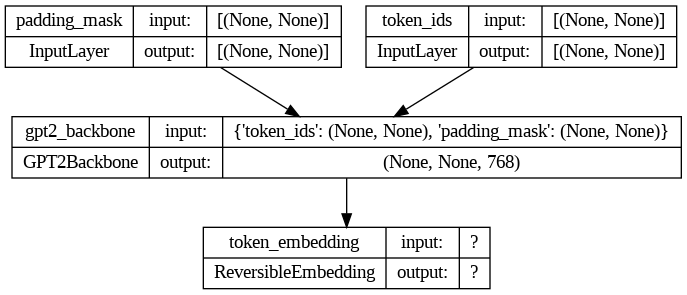

In [ ]:
tf.keras.utils.plot_model(lora_model, show_shapes=True)

### Inject LoRA layer into the model
We will now hack the original GPT-2 model and inject LoRA layers into it.

We will now override the original query/value projection matrices with our new LoRA layers.

In [ ]:
for layer_idx in range(lora_model.backbone.num_layers):
  # Change query dense layer.
  decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
  self_attention_layer = decoder_layer._self_attention_layer

  # Change query dense layer.
  self_attention_layer._query_dense = LoraLayer(self_attention_layer._query_dense,
                                                rank=RANK,
                                                alpha=ALPHA,
                                                trainable=True)

  # Change value dense layer.
  self_attention_layer._value_dense = LoraLayer(self_attention_layer._value_dense,
                                                rank=RANK,
                                                alpha=ALPHA,
                                                trainable=True)

In [ ]:
lora_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

Freeze the entire LLM, only the LoRA layers should be trainable.

In [ ]:
for layer in lora_model._flatten_layers():
  lst_of_sublayers = list(layer._flatten_layers())

  # print(len(lst_of_sublayers))
  if len(lst_of_sublayers) == 1:
    if layer.name in ["lora_A", "lora_B"]:
      # print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False

In [ ]:
# Summary of the model
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone (GPT2Backbone)                  │ (None, None, 768)                      │     124,587,264 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

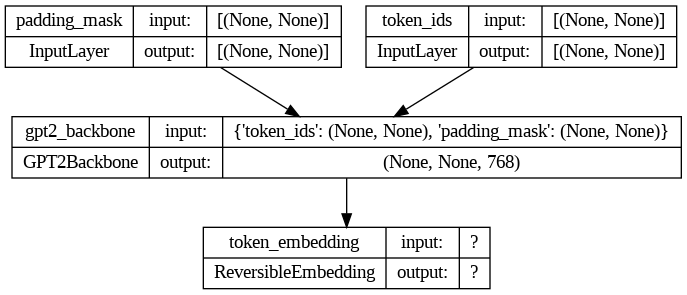

In [ ]:
tf.keras.utils.plot_model(lora_model, show_shapes=True)

### Helper function

In [ ]:
def get_optimizer_and_loss():
  optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5,
                                        weight_decay=0.01,
                                        epsilon=1e-6,
                                        global_clipnorm=1.0)  # Gradient clipping.

  # Exclude layernorm and bias terms from weight decay.
  optimizer.exclude_from_weight_decay(var_names=["bias"])
  optimizer.exclude_from_weight_decay(var_names=["gamma"])
  optimizer.exclude_from_weight_decay(var_names=["beta"])

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  return optimizer, loss

## Fine-tune LoRA GPT-2

In [ ]:
# Get the optimizer and loss value
optimizer, loss = get_optimizer_and_loss()

# Compile the model
lora_model.compile(loss=loss,
                   optimizer=optimizer,
                   weighted_metrics=["accuracy"])

In [ ]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone (GPT2Backbone)                  │ (None, None, 768)                      │     124,587,264 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

In [ ]:
# Fit the model on the training dataset
history = lora_model.fit(train_dataset,
                         epochs=2)

Epoch 1/2
500/500 [==============================] - 356s 711ms/step - loss: 3.4394 - accuracy: 0.3096
Epoch 2/2
500/500 [==============================] - 355s 709ms/step - loss: 3.4034 - accuracy: 0.3146


### Merge weights and generate text!

One of the biggest advantages of LoRA over other adapter methods is that it
does not incur any additional inference latency. Let's understand why.

Recall our LoRA equation: `output = W0x + b0 + BAx`. We can rewrite this as:
`output = = Wx + b0 = (W0 + BA)x + b0`, where `W = W0 + BA`. This means that if
we merge the weights of the original model and the adapter, we will be essentially
doing the same computation as the original model!

In [ ]:
for layer_idx in range(lora_model.backbone.num_layers):
  self_attention_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")._self_attention_layer

  # Merge query dense layer.
  query_lora_layer = self_attention_layer._query_dense

  A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
  B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
  increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
  query_lora_layer.original_layer.kernel.assign_add(increment_weights)

  # Merge value dense layer.
  value_lora_layer = self_attention_layer._value_dense

  A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
  B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
  increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
  value_lora_layer.original_layer.kernel.assign_add(increment_weights)

### Einsum

In simpler terms, this code (`tf.einsum("ab,bcd->acd", A_weights, B_weights)`) takes two tensors:

* A_weights: a matrix of size "a rows x b columns"
* B_weights: a matrix of size "b rows x c x d columns"

It multiplies them in a special way to produce a new tensor with dimensions:

* "a rows x c columns x d columns"

This is a powerful way to express complex calculations in a concise and elegant manner.


**Note**:
* tf.einsum is a TensorFlow function that performs tensor operations using Einstein notation.
* The code uses this function to multiply two tensors: A_weights and B_weights.
* The "ab,bcd->acd" string tells the function how to perform the multiplication.
* The arrows -> define the output tensor's dimensions.

In [ ]:
import time

def generate_text(model, input_text, max_length=200):
  start = time.time()

  output = model.generate(input_text, max_length=max_length)
  print(f"\nOutput: \n{output}")


  end = time.time()
  print(f"Total Time Elapsed: {end - start:.2f}s")

In [ ]:
generate_text(lora_model, "I like basketball", max_length=MAX_GENERATION_LENGTH)
generate_text(lora_model, "That Italian restaurant is", max_length=MAX_GENERATION_LENGTH)


Output:
I like basketball, and i play the game with friends and play games with them. 

so today we have a friend that we play with, he was playing in his room, and he had the ball.  

so he was trying to hit a ball, and i'm trying to get the ball to his left. 

so i'm in a game with the kids, and he's trying to hit the ball in a way. 

he tries to hit the ball, but he hits it too hard.  

i
Total Time Elapsed: 0.61s

Output:
That Italian restaurant is closed today, so i had a great time. i have a good friend, a very nice guy, that's been with me for about 3 years. 

so, he is the only man i know that i really care about in a relationship, and it's a good time to have him around. 

so we had a great time, and he was the only person i knew that he really cared about. 

we were going to a good party at a local restaurant, and i got
Total Time Elapsed: 0.52s
